## Issues

-figure out best way to handle dimensions for euclidean and cosine distance
   
   -test how they work with different dimensions: diff combinations of nx1,
    nxp, 1xn, nxm, etc.
   
   -cosine distance may need troubleshooting
   
   -new_x getting changed when scaled?
   
-better way to organize predictions within knn class: maybe need Prediction 
    subclass? Don't like how predict() stores attributes for a single pred
    as attributes of the instance as a whole

## K Nearest Neighbors

In [310]:
import numpy as np

In [2]:
def classify_response(val):
    """Parse response column from csv."""
    return (val == 'Abnormal') * 1

In [ ]:
def scale_mean(df, fitted_stats=None):
    """Pass in df of features. Scale each column by subtracting 
    its mean and dividing by its standard deviation. Return an array 
    with these statistics for each column.
    """
    if fitted_stats is not None:
        means, stds = fitted_stats
    else:
        means = np.mean(df, axis=0)
        stds = np.std(df, axis=0)
    df[:,:] = (df - means) / stds
    return means, stds

In [ ]:
def scale_minmax(df, fitted_stats=None):
    """Pass in df of features. Scale each column so its values 
    lie between 0 and 1. Return an array with min and max for each
    column.
    """
    if fitted_stats is not None:
        mins, maxes = fitted_stats
    else:
        mins = np.min(df, axis=0)
        maxes = np.max(df, axis=0)
    df[:,:] = (df - mins) / (maxes - mins)
    return mins, maxes

In [ ]:
def euclidean(vec1, vec2):
    """Find euclidean distance between two ndarrays (rank 2).
    """
    assert len(vec1.shape) == len(vec2.shape) == 2,\
        'Vectors must be 2d arrays'
    return np.sqrt(np.sum((vec1 - vec2) ** 2, axis=1))

In [ ]:
def cosine_distance(vec1, vec2):
    """Find cosine distance between two vectors. Both vectors should be 
    ndarrays of shape (n, 1).
    """
    assert len(vec1.shape) == len(vec2.shape) == 2,\
        'Vectors must be 2d arrays'
    zeros = np.zeros(shape=vec1.shape)
    print(vec1.T @ vec2)
    print(euclidean(vec1, zeros))
#     sim = (vec1.T @ vec2) / (euclidean(vec1, zeros) * euclidean(vec2, zeros))
#     return 1 - sim

In [408]:
def mode(classes):
    """Find the most common class from a list or array of numbers."""
    class_counts = [(c, list(classes).count(c)) for c in set(classes)]
    return sorted(class_counts, key=lambda x: x[1], reverse=True)[0][0]

In [409]:
class KNN_classifier():
    
    def __init__(self, X_train, y_train, k=5, scale_method='mean', 
                 distance='euclidean'):
        self.X = X_train
        self.y = y_train
        self.k = k
        self.scale_method = scale_method
        self.distance = distance

    def scale_features(self, df=None, stats=None):
        """Scale features using specified method."""
        df = self.X if df is None else df
        if self.scale_method == 'mean':
            self.stats = scale_mean(df, fitted_stats=stats)
        elif self.scale_method == 'minmax':
            self.stats = scale_minmax(df, fitted_stats=stats)
            
    def find_neighbors(self, k):
        """Return indices of the k observations with the smallest
        distances.
        """
        return np.argsort(self.distances)[:k]

    def predict(self, X_new, k=5):
        """Pass in 2d array of x values. Return indices and distances of
        k nearest neighbors from the train set."""
        self.scale_features(X_new, stats=self.stats)
        if self.distance == 'euclidean':
            self.distances = euclidean(X_new, self.X)
        elif self.distance == 'cosine':
            self.distances = cosine_distance(X_new, self.X)
        self.nearest_neighbors = self.find_neighbors(self.k)
        self.neighbor_distances = self.distances[self.nearest_neighbors]
        
        # Select most common class among nearest neighbors.
        self.neighbor_classes = self.y[self.nearest_neighbors]
        self.predicted_class = mode(self.neighbor_classes)
        return dict(predicted_class=self.predicted_class,
                    nearest_neighbors=self.nearest_neighbors,
                    neighbor_classes=self.neighbor_classes,
                    neighbor_distances=self.neighbor_distances)
    
    def __str__(self):
        """Display object details when printed."""
        return (f'KNN_classifier(k={self.k}, distance={self.distance},'
                f' scale_method={self.scale_method})')
    
    def __repr__(self):
        """Display object details when called in interactive mode."""
        return self.__str__()

In [458]:
X = np.loadtxt('bio.csv', skiprows=1, delimiter=',', usecols=range(6))
y = np.loadtxt('bio.csv', skiprows=1, delimiter=',', usecols=6, dtype=np.str)
y = classify_response(y)

In [459]:
mod = KNN_classifier(X_train=X, y_train=y, scale_method='mean',
                     distance='euclidean')
mod.scale_features()
mod

KNN_classifier(k=5, distance=euclidean, scale_method=mean)

In [460]:
np.random.seed(1)
new_x = np.random.rand(1, 6) * 60
print(new_x)
predictions = mod.predict(X_new=new_x)
print(new_x)
predictions

[[2.50213203e+01 4.32194696e+01 6.86248904e-03 1.81399544e+01
  8.80535345e+00 5.54031569e+00]]
[[-2.06147697  2.5696756  -2.80305268 -1.85158362 -8.20670021 -0.55352707]]


{'predicted_class': 1,
 'nearest_neighbors': array([  9, 173, 167, 209, 190]),
 'neighbor_classes': array([1, 1, 1, 1, 1]),
 'neighbor_distances': array([7.30992857, 7.37315008, 7.37681277, 7.49603059, 7.64047412])}

## Scikit-Learn Implementation

In [448]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [449]:
df = pd.read_csv('bio.csv')
X = df.iloc[:, :-1]
y = (df['class'] == 'Abnormal') * 1
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


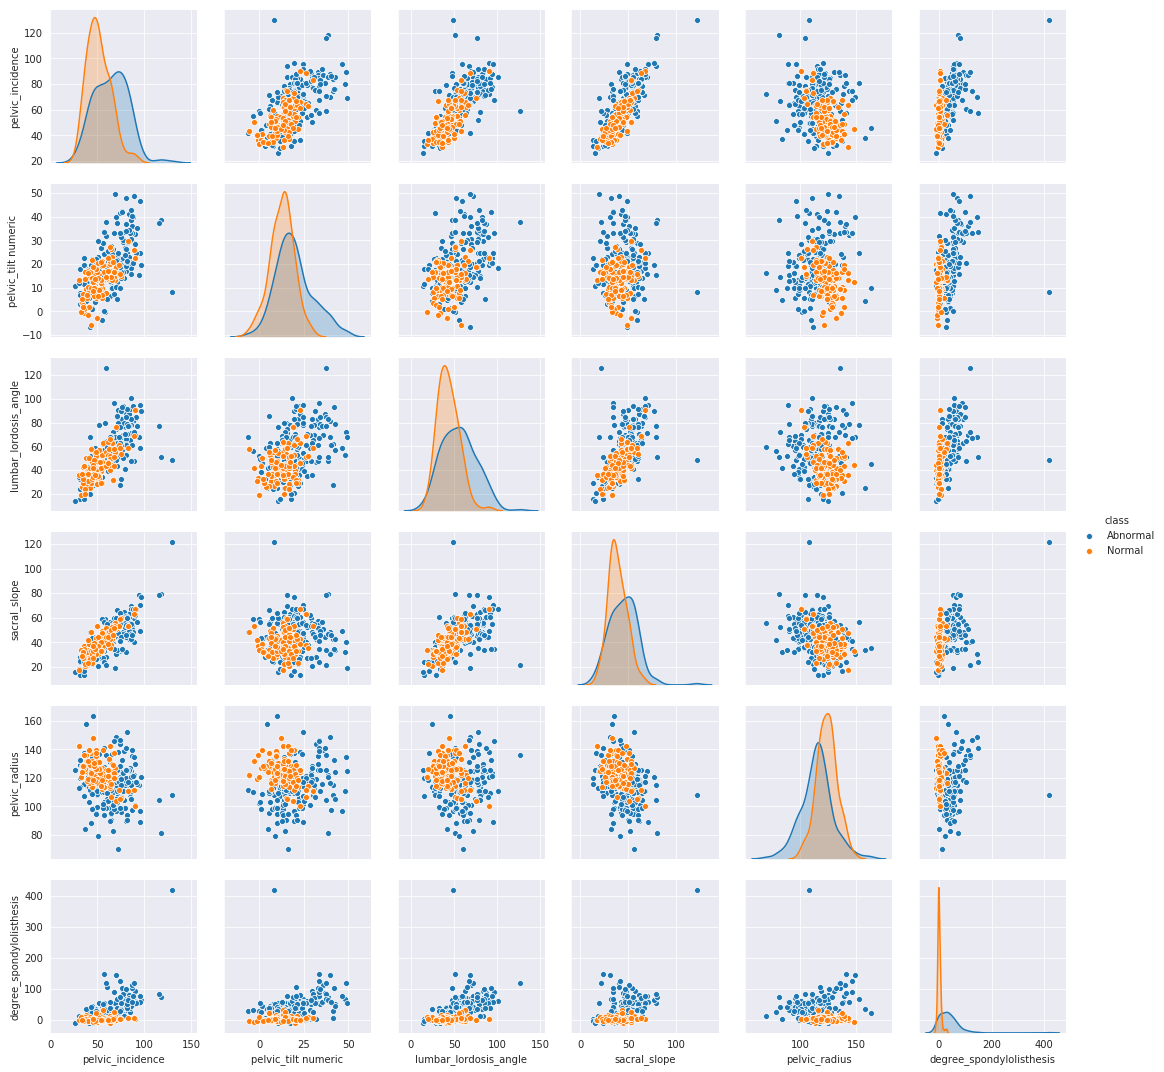

In [425]:
sns.pairplot(data=df, hue='class')
plt.show()

In [441]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [442]:
sk_knn = KNeighborsClassifier(n_neighbors=5)
sk_knn.fit(X_scaled, y)
pred = sk_knn.predict(new_x)[0]
distances, kneighbors = sk_knn.kneighbors(new_x)

In [443]:
print(f'Predicted class: {pred}')
print(f'Nearest neighbors: {kneighbors.flatten()}')
print(f'Neighbor distances: {distances.flatten()}')

Predicted class: 1
Nearest neighbors: [  9 173 167 209 190]
Neighbor distances: [7.30992857 7.37315008 7.37681277 7.49603059 7.64047412]
